## Evaluate and refine search results for equipment prices
LLM application using LangGraph to evaluate the results obtained from the first run of the Tavily search. If the results are deemed unsatisfactory by the agent, new search results should be tried until the result is satisfactory, or the maximum number of operations is reached.

In [1]:
# Import main packages
import pandas as pd
import os
import gc
import json

# Define directories
def find_directory_upwards(dir_name):
    """
    Find the absolute path to a directory with the given name by searching upwards
    from the current notebook's directory.

    Parameters:
    dir_name (str): The name of the directory to find.

    Returns:
    str: The absolute path to the directory if found, otherwise None.
    """
    # Get the current notebook's directory
    current_dir = os.getcwd()
    
    while True:
        # Check if the directory exists in the current directory
        potential_path = os.path.join(current_dir, dir_name)
        if os.path.isdir(potential_path):
            return potential_path
        
        # Move to the parent directory
        parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
        
        # If the current directory is the root directory, stop searching
        if current_dir == parent_dir:
            break
        
        current_dir = parent_dir
    
    # If the directory is not found, return None
    return None

code_dir = find_directory_upwards('codes')
# raw_data_dir = find_directory_upwards('raw_data')
int_data_dir = find_directory_upwards('int_data')
output_dir = find_directory_upwards('output')
ucctextextract_dir = find_directory_upwards('ucc_text_extract')

print(code_dir)
# print(raw_data_dir)
print(int_data_dir)
print(output_dir)
print(ucctextextract_dir)

/home/sosajuanbautista/aeai-filestore/projects/agentic/codes
/home/sosajuanbautista/aeai-filestore/projects/agentic/int_data
/home/sosajuanbautista/aeai-filestore/projects/agentic/output
/home/sosajuanbautista/aeai-filestore/projects/ucc_text_extract


## Retrieve initial search results

In [2]:
#Load JSON with search results
path = os.path.join(int_data_dir, 'commodity_price_sources', 'commodity_tavily_search_results.json')
with open(path, 'r') as file:
    data = json.load(file)
print(len(data))
print(data.keys())

20
dict_keys(['Rotary tiller or power tiller', 'Farming excavator', 'Mowers', 'Track excavators', 'Forklifts', 'Automobiles or cars', 'Battery energy storage control and management system', 'Solar power plants', 'General tool kits', 'Trim or molding tools', 'Gabion block', 'Toothbrush or tumbler holder', 'Computer server', 'Notebook computer', 'Desktop computer', 'Personal computer', 'Photocopiers', 'Multifunction machines', 'Office product equipment and stationery consumable', 'Inkjet printer for commercial printing applications'])


In [3]:
# data['Rotary tiller or power tiller']

In [4]:
# Let's start working with only one commodity
commodity = 'Rotary tiller or power tiller'
commodity_data = data[commodity]
# commodity_data

In [5]:
# print(commodity_data.keys())
# print(len(commodity_data['search_results'])) # One for each search term
# print(commodity_data['search_results'][0].keys())
# print(commodity_data['search_results'][0]['results'])
# print(commodity_data['search_results'][0]['results'][0].keys())

In [6]:
# Create a sample of search results to evaluate
evaluate_these_results = []
for search_term in commodity_data['search_results']:
    for r in commodity_data['search_results']:
        r_copy = {'query': r['query']}
        r_copy.update(r['results'][0])
        evaluate_these_results.append(r_copy)

def remove_duplicates(dict_list):
    seen_urls = set()
    unique_dicts = []
    
    for d in dict_list:
        url = d['url']
        if url not in seen_urls:
            unique_dicts.append(d)  # Add the dictionary if the URL hasn't been seen
            seen_urls.add(url)  # Mark the URL as seen
    
    return unique_dicts

evaluate_these_results = remove_duplicates(evaluate_these_results)

print(len(evaluate_these_results))


evaluate_these_results

3


[{'query': 'Rotary tiller or power tiller blue book',
  'title': "Rototiller Buyer's Guide - Harvest to Table",
  'url': 'https://harvesttotable.com/rototiller-buyers-guide-best-rated-tillers/',
  'content': 'Rototiller Buyer’s Guide Rototiller manufacturers make tillers in all shapes and sizes, from small, light models to large machines with good-sized motors and big rotating tines. If you have a small home garden, an electric corded rototiller should be adequate. If you have a large garden or heavy clay soil, you’ll need a large rototiller with a powerful engine. No matter what size garden or yard you have, be sure to choose a rototiller that is powerful enough to do the job. Here’s our guide to help you buy a rototiller: What are rototillers used for? What is a rototiller? rototillers Rototiller-cultivator buying tips A. A rear-tine, gas-powered rototiller can dig 8 to 10 inches deep. Rototiller Hedge Trimmer Buyer’s Guide',
  'score': 0.99394965,
  'raw_content': "\n\n\n\n\n\n\n\n\

In [7]:
len(commodity_data['search_results'])

3

## Define the AgentState and prompts

In [8]:
# Load API keys (for Tavily and OpenAI)
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [9]:
# # Try a search with Tavily
# query_text = 'Photocopiers used prices'
# from tavily import TavilyClient
# tavily_client = TavilyClient()
# response = tavily_client.search(
#     query=query_text, 
#     max_results=1,
#     include_raw_content=True
#     )
# response['results']

In [11]:
# Creating a class for the agent state
from typing import TypedDict, List, Dict

class AgentState(TypedDict):
    commodity: str # Name of commodity class
    search_results_to_evaluate: List[Dict[str, str]]  # List of search results to evaluate.
    evaluated_search_results: List[Dict[str, str]] # Dictionary with the agent's evaluation (and justification).
    min_approved_search_results: int # Minimum number of search results that need to be approved.
    iteration_number: int # Keeps track of the number of iterations made to
    max_evaluation_iterations: int # Maximum number of iterations allowed.
    n_refined_search_terms: int # Number of refined search terms.
    max_results_per_search_term: int # Number of results per search term.
    refined_search_terms: List[str] # List of refined search terms.

In [13]:
# Coerce the evaluation result to dictionary format
from langchain_core.pydantic_v1 import BaseModel, Field

class SearchResultEvaluation(BaseModel):
    evaluation_outcome: bool = Field(description="The outcome of the evaluation of the search result. True if the search result is relevant to the query, False otherwise.")
    justification: str = Field(description="A brief justification for the evaluation outcome.")

/home/sosajuanbautista/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3526: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List

class RefinedSearchTerms(BaseModel):
    refined_search_terms: List[str] = Field(description="A list of refined search terms")

## Implemeting the agents and the nodes

In [ ]:
# Initiate LLMs
from langchain_openai import ChatOpenAI
evaluator_model = ChatOpenAI(model='gpt-4o-mini', temperature=0)

In [ ]:
# Prompt for evaluation of serach results (fixed for all commodities)
SEARCH_RESULT_EVALUATION_PROMPT = f'''You are an expert analyst tasked with the evaluation of search results for online sources of product prices.
The products are categorized into different categories called "commodities". You will be presented with an individual search result for a particular category of commodities.
Using the information provided in the search result, you have to evaluate if the resulting webpage is useful for the purpose of retrieving prices for products that could be in that commodity category. To guide you in this task, consider the following points:
1. The following common search results are NOT USEFUL for the task: appraisal tools, product valuation calculators, general information about the product, user manuals, recommendations or rankings of the "best" products.
2. The following common search results are USEFUL for the task: product listings with prices, product catalogs with prices, list of multiple product models with prices.

# The search result for the commodity category is presented in dictionary format, where the key "query" is the search term used to obtain the search result, "title" is the title of the search result, "url" is the URL of the search result, "content" is a snippet or brief description of the search result, "score" is a similarity score outputed by the search engine, and "raw_content" is the parsed html content of the webpage.'''

In [15]:
from langchain_core.messages import SystemMessage, HumanMessage

In [16]:
# EVALUATOR NODE
def evaluate_search_result_node(state: AgentState):

    # Initiate/Get iteration number
    iteration_number = state.get('iteration_number', 1)

    # Load commodity
    commodity = state['commodity']
    if iteration_number==1:
        print("Performing evaluation for commodity: ", commodity)

    # Get the search results evaluated so far
    evaluated_search_results = state.get('evaluated_search_results', [])
    evaluated_urls = [search_result['url'] for search_result in evaluated_search_results]
    if len(evaluated_search_results) > 0:
        print("Amount of search results evaluated so far: ", len(evaluated_search_results))

    # Retrieve the evaluated search results from the state
    search_results_to_evaulate = state['search_results_to_evaluate']

    # Remove the duplicated URLs in the search results to evaluate
    def remove_duplicates(dict_list):
        seen_urls = set()
        unique_dicts = []
        for d in dict_list:
            url = d['url']
            if url not in seen_urls:
                unique_dicts.append(d)  # Add the dictionary if the URL hasn't been seen
                seen_urls.add(url)  # Mark the URL as seen
        return unique_dicts
    search_results_to_evaulate = remove_duplicates(search_results_to_evaulate)
    print("Amount of search results to evaluate: ", len(search_results_to_evaulate))

    for search_result in search_results_to_evaulate:

        # First check if the search result is already evaluated
        if search_result['url'] in evaluated_urls:
            print('Search result already evaluated, ignore:', search_result['title'], search_result['url'])
            continue

        print('Evaluating search result:', search_result['title'], search_result['url'])

        USER_SEARCH_RESULT_PROMPT = f'''This is the dictionary containing the search result for the commodity category "{commodity}":
        {search_result}.'''
    
        # Messages for the model
        messages = [
            SystemMessage(content=SEARCH_RESULT_EVALUATION_PROMPT),
            HumanMessage(content=USER_SEARCH_RESULT_PROMPT)
        ]

        # Model with structured output
        structured_model = evaluator_model.with_structured_output(SearchResultEvaluation)

        # Invoke model
        response = structured_model.invoke(messages)

        # Re-construct evaluated search result
        evaluated_search_result = search_result.copy()
        evaluated_search_result['evaluation_outcome'] = response.evaluation_outcome
        print("Evaluation outcome: ", response.evaluation_outcome)
        evaluated_search_result['justification'] = response.justification

        # Add the evaluated search result to the state with all the evaluated results
        evaluated_search_results.append(evaluated_search_result)

    # # Print the evaluated search results
    # approved_search_results = [r['title'] for r in evaluated_search_results if r['evaluation_outcome']]
    # print(f"Approved {len(approved_search_results)} search results: {approved_search_results}")
    # disapproved_search_results = [r['title'] for r in evaluated_search_results if not r['evaluation_outcome']]
    # print(f"Disapproved {len(disapproved_search_results)} search results: {disapproved_search_results}")

    # Empty the search results to evaluate
    state['search_results_to_evaluate'] = []

    # Update the iteration number
    iteration_number = state.get('iteration_number', 0)
    iteration_number += 1

    return {"evaluated_search_results": evaluated_search_results, 
            'search_results_to_evaulate': search_results_to_evaulate,
            'iteration_number': iteration_number} 

In [17]:
# REFINED SEARCH TERM NODE
def refine_search_term_node(state: AgentState):

    # Initiate a model (the temperature will increase in each iteration)
    iteration_number = state.get('iteration_number')
    temp = min(0.1 + 0.2*iteration_number, 1)
    search_term_refinement_model = ChatOpenAI(model='gpt-4o-mini', temperature=temp)

    # Retrieve the evaluated search results from the state
    evaluated_search_results = state.get('evaluated_search_results', [])
    commodity = state['commodity']
    n_refined_search_terms = state.get('n_refined_search_terms', 1) # default is 1

    # Retrieve the search terms that received approval and disapproval
    all_search_terms = [evaluated_result['query'] for evaluated_result in evaluated_search_results]
    approved_search_terms = [evaluated_result['query'] for evaluated_result in evaluated_search_results if evaluated_result['evaluation_outcome']==True]
    disapproved_search_terms = [evaluated_result['query'] for evaluated_result in evaluated_search_results if evaluated_result['evaluation_outcome']==False]

    # Define the prompt
    SYSTEM_REFINEMENT_PROMPT = f'''You are an expert analyst tasked with refining search terms to improve the quality of search results for online sources of product prices for the following category of products: {commodity}.

    An initial search was conducted using the following search terms: {all_search_terms}.

    The following criteria were used to evaluate the search results obtained:
    1. The following common search results should be DISAPPROVED: appraisal tools, product valuation calculators, general information about the product, user manuals, recommendations of the 'best' products, product rankings.
    2. The following common search results should be APPROVED: product listings with prices, product catalogs with prices, list of multiple product models with prices.

    Based on the evaluation of the search results, the following search terms were approved: {approved_search_terms}.
    The following search terms were disapproved: {disapproved_search_terms}.'''
    
    USER_REFINEMENT_PROMPT = f'''Based on the information given to you in the system message, provide {n_refined_search_terms} refined search terms that you think would yield more relevant results.
    Do NOT repeat any of the search terms used so far, regardless of whether they were approved.'''

    # Messages for the model
    messages = [
        SystemMessage(content=SYSTEM_REFINEMENT_PROMPT),
        HumanMessage(content=USER_REFINEMENT_PROMPT)
    ]

    # Model with structured output
    structured_model = search_term_refinement_model.with_structured_output(RefinedSearchTerms)

    # Invoke model
    response = structured_model.invoke(messages)

    # Make sure that the refined search terms have not been used before
    refined_search_terms = response.refined_search_terms
    refined_search_terms = [term for term in refined_search_terms if term not in all_search_terms]

    # Print the refined search terms that were discarded
    if len(response.refined_search_terms) != len(refined_search_terms):
        print("The following refined search terms were discarded because they were already used: ", [term for term in response.refined_search_terms if term in all_search_terms])

    print("Refined search terms: ", refined_search_terms)
    
    return {"refined_search_terms": refined_search_terms}

In [18]:
# SEARCH NODE
def search_node(state: AgentState):

    # Retrieve from the state
    refined_search_terms = state.get('refined_search_terms', [])
    max_results_per_search_term = state.get('max_results_per_search_term', 3) # default is 3
    
    # Create empty list of dictionaries to store search results
    search_results = []

    # Initiate the Tavily client
    from tavily import TavilyClient
    tavily_client = TavilyClient() # API key is stored in the environment variable

    # Make an API call to Tavily
    for term in refined_search_terms:
        print('Searching for:', term)
        response = tavily_client.search(
                query=term, 
                max_results=max_results_per_search_term,
                include_raw_content=True
                )
        print("Amount of results found for this search term: ", len(response['results']))
        for result in response['results']:
            result['query'] = term
            search_results.append(result)

    print("Amount of search results added for evaluation: ", len(search_results))
    # print('AUX. These are the search results to evaluate:', search_results)

    return {"search_results_to_evaluate": search_results}

## Conditional edges

In [19]:
# Defining the conditional edge
from langgraph.graph import END

def count_approved_search_results(state):

    evaluated_search_results = state.get('evaluated_search_results', [])
    min_approved_search_results = state.get('min_approved_search_results', 1)
    iteration_number = state.get('iteration_number')
    print("Just finished iteration number: ", iteration_number)
    max_evaluation_iterations = state.get('max_evaluation_iterations', 2)

    approved_search_results = [evaluated_result for evaluated_result in evaluated_search_results if evaluated_result['evaluation_outcome']==True]
    
    print(f"Count of approved search results: {len(approved_search_results)}")

    if len(approved_search_results) >= min_approved_search_results:
        print("Minimum number of approved search results reached. End of pipeline.")
        print("Final approved search results: ")
        for approved_result in approved_search_results:
            print(approved_result['title'], approved_result['url'])
        return END
    elif iteration_number >= max_evaluation_iterations:
        print("Maximum number of iterations reached. End of pipeline.")
        print("Final approved search results: ")
        for approved_result in approved_search_results:
            print(approved_result['title'], approved_result['url'])
        return END
    else:
        print("Minimum number of approved search results not reached. Continue to next iteration.")
        return 'refine_search_terms'

## Define the graph

In [20]:
from langgraph.graph import StateGraph, END

# Instantiating the state graph builder
builder = StateGraph(AgentState)

# Adding nodes to the graph (no particular order needed here, I think)
# Here we associate the names of the nodes with the functions we defined earlier.
builder.add_node('evaluator_of_search_results', evaluate_search_result_node)
builder.add_node('refine_search_terms', refine_search_term_node)
builder.add_node('search_web', search_node)

# Setting the entry point of the state graph
builder.set_entry_point('evaluator_of_search_results')

# Adding regular edges
builder.add_edge('refine_search_terms', 'search_web')
builder.add_edge('search_web', 'evaluator_of_search_results')

# Adding conditional edges
builder.add_conditional_edges(
    'evaluator_of_search_results', # after this
    count_approved_search_results, # run this function
    {END: END, 'refine_search_terms': 'refine_search_terms'} # !!! Fix this to expand the graph
)

# # Finish point
# builder.set_finish_point('evaluator_of_search_results')

In [21]:
# Compile the graph
# The SQLiteSaver class is used to save the state of the agent to a SQLite database, ensuring that the progress can be tracked and resumed.
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver

memory = SqliteSaver.from_conn_string(':memory:')

# graph = builder.compile(checkpointer=memory) # fix - change to this:
graph = builder.compile(checkpointer=MemorySaver())

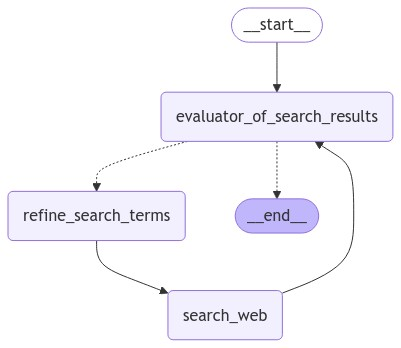

In [22]:
# Visualize the graph
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## Run the app

In [23]:
# Configure the thread. This allows handling multiple sessions independently.
thread = {'configurable': {'thread_id': '1'}}

In [24]:
print(commodity)
print(evaluate_these_results)
print(len(evaluate_these_results))

Rotary tiller or power tiller
[{'query': 'Rotary tiller or power tiller blue book', 'title': "Rototiller Buyer's Guide - Harvest to Table", 'url': 'https://harvesttotable.com/rototiller-buyers-guide-best-rated-tillers/', 'content': 'Rototiller Buyer’s Guide Rototiller manufacturers make tillers in all shapes and sizes, from small, light models to large machines with good-sized motors and big rotating tines. If you have a small home garden, an electric corded rototiller should be adequate. If you have a large garden or heavy clay soil, you’ll need a large rototiller with a powerful engine. No matter what size garden or yard you have, be sure to choose a rototiller that is powerful enough to do the job. Here’s our guide to help you buy a rototiller: What are rototillers used for? What is a rototiller? rototillers Rototiller-cultivator buying tips A. A rear-tine, gas-powered rototiller can dig 8 to 10 inches deep. Rototiller Hedge Trimmer Buyer’s Guide', 'score': 0.99394965, 'raw_content'

In [25]:
# Start the prompt dictionary.
prompt = {
    'commodity': commodity,
    'search_results_to_evaluate': evaluate_these_results,
    'min_approved_search_results': 10, # default is 1
    'n_refined_search_terms': 3, # default is 1
    'max_results_per_search_term': 2, # default is 3
    'max_evaluation_iterations': 3, # default is 1
}

response = graph.invoke(prompt, thread)
response

Performing evaluation for commodity:  Rotary tiller or power tiller
Amount of search results to evaluate:  3
Evaluating search result: Rototiller Buyer's Guide - Harvest to Table https://harvesttotable.com/rototiller-buyers-guide-best-rated-tillers/


Evaluation outcome:  False
Evaluating search result: Rotary Tillers For Sale | MyLittleSalesman.com https://www.mylittlesalesman.com/rotary-tillers-for-sale-i6c766f0m0
Evaluation outcome:  True
Evaluating search result: Tillers - Rototillers & Cultivators - The Home Depot https://www.homedepot.com/b/Outdoors-Outdoor-Power-Equipment-Rototillers-Cultivators-Tillers/N-5yc1vZbxd8
Evaluation outcome:  True
Approved 2 search results: [{'query': 'Rotary tiller or power tiller used prices', 'title': 'Rotary Tillers For Sale | MyLittleSalesman.com', 'url': 'https://www.mylittlesalesman.com/rotary-tillers-for-sale-i6c766f0m0', 'content': 'Rotary Tillers For Sale AGRIC (1)BREVIGLIERI (1)Bush Hog (8)CELLI (1)Frontier (3)IRONCRAFT (11)John Deere (1)Kuhn (2)Land Pride (48)Maschio (18)NORDLAND (3)RANKIN (1)Rhino (2)Roll-a-cone (1)TAR RIVER (5)Unmarked (5)Unverferth (1)Woods (12)Yetter (2) 2023 Land Pride RGR1274 Rotary Tiller 2023 Land Pride RGR1266 Rotary Tiller 2023 Land Pride RGR1258 Rotary Tiller

{'commodity': 'Rotary tiller or power tiller',
 'search_results_to_evaluate': [{'title': "Rototiller Buyer's Guide - Harvest to Table",
   'url': 'https://harvesttotable.com/rototiller-buyers-guide-best-rated-tillers/',
   'content': 'Rototiller Buyer’s Guide Rototiller manufacturers make tillers in all shapes and sizes, from small, light models to large machines with good-sized motors and big rotating tines. If you have a small home garden, an electric corded rototiller should be adequate. If you have a large garden or heavy clay soil, you’ll need a large rototiller with a powerful engine. No matter what size garden or yard you have, be sure to choose a rototiller that is powerful enough to do the job. Here’s our guide to help you buy a rototiller: What are rototillers used for? What is a rototiller? rototillers Rototiller-cultivator buying tips A. A rear-tine, gas-powered rototiller can dig 8 to 10 inches deep. Rototiller Hedge Trimmer Buyer’s Guide',
   'score': 0.9575962,
   'raw_c

In [232]:
response['evaluated_search_results']

[{'title': "Rototiller Buyer's Guide - Harvest to Table",
  'url': 'https://harvesttotable.com/rototiller-buyers-guide-best-rated-tillers/',
  'content': 'Rototiller Buyer’s Guide Rototiller manufacturers make tillers in all shapes and sizes, from small, light models to large machines with good-sized motors and big rotating tines. If you have a small home garden, an electric corded rototiller should be adequate. If you have a large garden or heavy clay soil, you’ll need a large rototiller with a powerful engine. No matter what size garden or yard you have, be sure to choose a rototiller that is powerful enough to do the job. Here’s our guide to help you buy a rototiller: What are rototillers used for? What is a rototiller? rototillers Rototiller-cultivator buying tips A. A rear-tine, gas-powered rototiller can dig 8 to 10 inches deep. Rototiller Hedge Trimmer Buyer’s Guide',
  'score': 0.99394965,
  'raw_content': "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLatest stories\

In [ ]:
response['evaluated_search_results'][0]

In [ ]:
response['evaluated_search_results'][0]['evaluation_outcome']

In [ ]:
response['evaluated_search_results']

In [ ]:
[evaluated_result['query'] for evaluated_result in response['evaluated_search_results'] if evaluated_result['evaluation_outcome']==True]

In [ ]:
[evaluated_result['query'] for evaluated_result in response['evaluated_search_results'] if evaluated_result['evaluation_outcome']==False]